참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [3]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 9.0 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=c7c02e94313d0e33e1aa129b28756af79be26b44c2b11e17fa34fe0c83ea27ff
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1289k      0  0:00:01  0:00:01 --:--:-- 2578k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [6]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [7]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [8]:
train_data['label'].value_counts()

1    80003
0    79923
Name: label, dtype: int64

### 데이터 정제 및 전처리

In [9]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

<ipython-input-9-b3393058b13d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-9-b3393058b13d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


### 토큰화

In [10]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

In [11]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [12]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
# vocab_size 설
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩




In [14]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 86
리뷰의 평균 길이 : 15.648831334492202


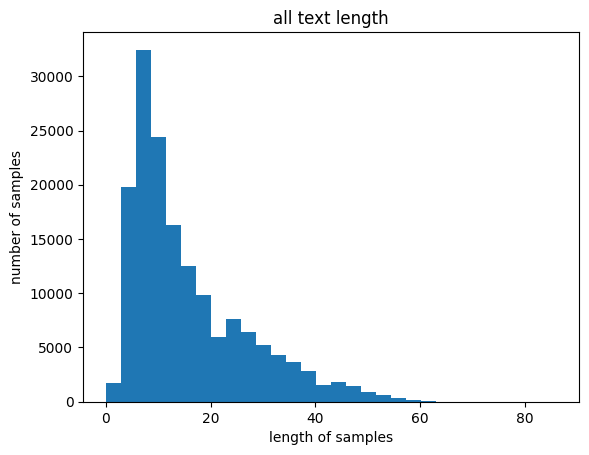

In [15]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9564986306166602


In [17]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [18]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [19]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [20]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [21]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [22]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.34329405426979065. Accuracy: 83.23995971679688
Iteration: 1000. Loss: 0.38351646065711975. Accuracy: 86.9691390991211
Iteration: 1500. Loss: 0.48798277974128723. Accuracy: 83.56510162353516
Iteration: 2000. Loss: 0.40686503052711487. Accuracy: 85.84613037109375
Iteration: 2500. Loss: 0.45058056712150574. Accuracy: 88.23220825195312
Iteration: 3000. Loss: 0.1942269206047058. Accuracy: 88.72242736816406
Iteration: 3500. Loss: 0.13168476521968842. Accuracy: 88.72242736816406
Iteration: 4000. Loss: 0.27205690741539. Accuracy: 88.60737609863281
Iteration: 4500. Loss: 0.20252789556980133. Accuracy: 87.95708465576172
Iteration: 5000. Loss: 0.22881226241588593. Accuracy: 89.38772583007812
Iteration: 5500. Loss: 0.17618100345134735. Accuracy: 89.49527740478516
Iteration: 6000. Loss: 0.15034963190555573. Accuracy: 89.65034484863281
Iteration: 6500. Loss: 0.22513484954833984. Accuracy: 89.2851791381836
Iteration: 7000. Loss: 0.26598894596099854. Accuracy: 89.59031677246094

### 모델학습 (LSTM, Long short term memory)

In [24]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [25]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [26]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.20935265719890594. Accuracy: 90.6707992553711
Iteration: 2000. Loss: 0.36872026324272156. Accuracy: 91.22354888916016
Iteration: 3000. Loss: 0.12378194183111191. Accuracy: 91.34110260009766
Iteration: 4000. Loss: 0.11993434280157089. Accuracy: 91.54869842529297
Iteration: 5000. Loss: 0.23910988867282867. Accuracy: 91.44364929199219
Iteration: 6000. Loss: 0.08997150510549545. Accuracy: 91.20104217529297
Iteration: 7000. Loss: 0.2350892871618271. Accuracy: 91.24606323242188
Iteration: 8000. Loss: 0.036012399941682816. Accuracy: 91.01596069335938
Iteration: 9000. Loss: 0.14326731860637665. Accuracy: 91.20104217529297
Iteration: 10000. Loss: 0.027388814836740494. Accuracy: 91.44615173339844
Iteration: 11000. Loss: 0.1655743420124054. Accuracy: 90.97344207763672
Iteration: 12000. Loss: 0.17041169106960297. Accuracy: 91.15602111816406
Iteration: 13000. Loss: 0.07397112995386124. Accuracy: 90.98094177246094
Iteration: 14000. Loss: 0.08998682349920273. Accuracy: 91.085

### 모델 학습 (Gated Recurrent Unit (GRU))

In [27]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [28]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [29]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.38762497901916504. Accuracy: 90.29312896728516
Iteration: 2000. Loss: 0.2759040594100952. Accuracy: 91.32609558105469
Iteration: 3000. Loss: 0.1742049902677536. Accuracy: 91.3486099243164
Iteration: 4000. Loss: 0.16992413997650146. Accuracy: 91.27607727050781
Iteration: 5000. Loss: 0.18260188400745392. Accuracy: 91.4161376953125
Iteration: 6000. Loss: 0.1376020610332489. Accuracy: 91.33110046386719
Iteration: 7000. Loss: 0.12913253903388977. Accuracy: 91.32359313964844
Iteration: 8000. Loss: 0.1328110694885254. Accuracy: 91.12100219726562
Iteration: 9000. Loss: 0.12590470910072327. Accuracy: 90.92591857910156
Iteration: 10000. Loss: 0.11998835951089859. Accuracy: 91.05847930908203
Iteration: 11000. Loss: 0.13414059579372406. Accuracy: 90.94842529296875
Iteration: 12000. Loss: 0.2242203652858734. Accuracy: 91.02596282958984
Iteration: 13000. Loss: 0.15868233144283295. Accuracy: 90.81836700439453
Iteration: 14000. Loss: 0.18762683868408203. Accuracy: 90.823371887

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!


# Accuracy
- 마지막 Iteration 기준으로 비교
- Vanilla RNN: Iteration: 37000. Loss: 0.32618194818496704. Accuracy: 88.08714294433594
- LSTM: Iteration: 37000. Loss: 0.019116278737783432. Accuracy: 90.16557312011719
- GRU: Iteration: 37000. Loss: 0.1760690063238144. Accuracy: 89.63533782958984
- 이론상 LSTM, GRU는 성능 비슷하다고 하였음. RNN보단 낫고, 비슷한 거 같긴 하다. 다만 Loss가 동일한 CE를 썼음에도 불구하고 많이 차이가 난다... Iteration을 좀 길게 보면 loss가 튀는 거 같아 보인다. lr, mini batch size을 좀 수정해야 할듯...